In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random as rnd
from scipy.ndimage import convolve
from tqdm import tqdm

class DBM_cube:

    def __init__(self,
                 N = 40,
                 dimensions=None,
                 nu=1.5,
                 debug=False,
                 threshold = 0.0001):

        # Unless specified, expect grid of NxNxN dimension, in order z, x, y
        if dimensions is None:
            self.dim = {'height': N, 'width': N,'depth': N}
        else:
            self.dim = {'height': dimensions[0], 'width': dimensions[1],'depth': dimensions[2]}

        # Create encoding grid and set all to 0
        #  0 encodes unfixed potential
        #  anything else encodes fixed potential
        # (I also use this grid to track order of cells in lightning structure)
        self.fixed_grid = np.zeros(shape=list(self.dim.values()))

        # Set all boundaries to be fixed
        self.fixed_grid[:, :, 0] = -1  # front boundary
        self.fixed_grid[:, :, -1] = -1  # back boundary
        self.fixed_grid[:, 0, :] = -1  # left boundary
        self.fixed_grid[:, -1, :] = -1  # right boundary
        self.fixed_grid[0, :, :] = -1  # top boundary
        self.fixed_grid[-1, :, :] = -1  # bottom boundary

        # The electric potential
        self.potential = np.zeros(shape=list(self.dim.values()))

        # The lightning downwards-tendency parameter
        self.nu = nu

        # Number of update steps
        self.steps = 1

        # To debug or not
        self.debug = debug

        # Keep track of current neighbors of structure
        self.structure_neighbors = set()

        self.struck_ground = False

        self.threshold = threshold

        # Debugging lists
        self.difference_per_conv = []
        self.overall_sum = []

        # Neighborhood
        self.neighbors = [(1, 0, 0), (0, 1, 0), (0, 0, 1), 
                         (-1, 0, 0), (0,-1, 0), (0, 0,-1)]
        
        # Setup initial electric potential
        self.initial_electric_pot()

        # Add the first cell as a structure neighbor
        self.structure_neighbors.add((0, self.dim['width']//2, self.dim['depth']//2))
        # Update structure with that cell
        self.expand_lightning_to((0, self.dim['width']//2, self.dim['depth']//2))

        self.steps += 1


    def strike_lightning(self):

        # Run update until lightning strikes ground
        self.struck_ground = False

        # Create a tqdm tracker
        if self.debug:
            progress_bar = tqdm(total=self.dim['height'], desc="How close the lightning is to the ground", unit="iter")

        while not self.struck_ground:
            # Update lightning
            self.update()

            if self.debug:
                # If the newly added cell made the lightning stretch one step lower, update dist_to_ground
                if self.dim['height'] - self.newest_neighbor[0] < self.dist_to_ground:
                    self.dist_to_ground = self.dim['height'] - self.newest_neighbor[0]
                    progress_bar.update(1)

    def update(self):

        weights = []
        # For each structure neighbor
        for neighbor_pos in self.structure_neighbors:
            # Raise each weight to the power of nu
            weights.append(self.potential[neighbor_pos[0], neighbor_pos[1], neighbor_pos[2]] ** self.nu)
        
        # Choose a random neighbor with the weighting
        chosen_cell = rnd.choices(list(self.structure_neighbors), weights)[0]

        # Update lightning grid, potential and newest neighbor
        self.expand_lightning_to(chosen_cell)

        self.steps += 1

    def initial_electric_pot(self):

        # Create a linear gradient along the depth axis
        gradient = np.linspace(0, 1, self.dim['height'])[:, np.newaxis, np.newaxis]

        # Apply the gradient to the array
        self.potential += gradient



    def expand_lightning_to(self, pos):
        '''
        Updates correpsonding grids
        Update neighborhood of lightning structure
        Call method to update electric potential
        '''

        self.newest_neighbor = pos

        # Remove the potential
        self.potential[pos[0], pos[1], pos[2]] = 0

        # Set it as a fixed cell
        self.fixed_grid[pos[0], pos[1], pos[2]] = self.steps

        # Update structure neighbors
        self.structure_neighbors.remove(pos)
        for neighbor_delta in self.neighbors:
            neighbor_pos = (pos[0] + neighbor_delta[0], pos[1] + neighbor_delta[1], pos[2] + neighbor_delta[2])
            if neighbor_pos[0] == self.dim['height']:
                self.struck_ground = True
                break

            if neighbor_pos[0] >= 0 and neighbor_pos[0] < self.dim['height'] and \
                neighbor_pos[1] >= 0 and neighbor_pos[1] < self.dim['width'] and \
                neighbor_pos[2] >= 0 and neighbor_pos[2] < self.dim['depth'] and \
                self.potential[neighbor_pos[0], neighbor_pos[1], neighbor_pos[2]] != 0:
                    self.structure_neighbors.add(neighbor_pos)

        if not self.struck_ground:
            # Update the rest of the potential
            self.potential = self.update_electric_potential()


    def update_electric_potential(self):
        '''
        Uses iterative diffusion to estimate solution to Laplace equation.
        Tracks percentual change for each cell after each diffusion, 
        terminates when the largest percentual change is less than threshold
        '''
        
        # Make ground and lightning structure fixed
        no_change_mask = self.fixed_grid != 0


        old_potential = np.copy(self.potential)
        new_potential = np.copy(old_potential)

        # Until threshold
        while True:
            neighbor_avgs = np.zeros_like(new_potential)
            for dim in range(3):
                neighbor_avgs += np.roll(new_potential, shift=1, axis=dim)
                neighbor_avgs += np.roll(new_potential, shift=-1, axis=dim)
            neighbor_avgs /= 6  # Divided by the number of neighbors   

            new_potential = neighbor_avgs
                        
            # Reset the cells that shouldn't change
            new_potential[no_change_mask] = self.potential[no_change_mask]

            if self.debug:
                self.difference_per_conv.append(np.sum(abs(np.array(new_potential) - np.array(old_potential))))
                self.overall_sum.append(np.sum(np.array(new_potential)))

            # percentual change relative to previous iteration
            rel_differences = abs(np.array(new_potential) - np.array(old_potential))/np.array(old_potential)

            # Terminate when max percentual change is small (below threshold)
            if np.nanmax(rel_differences) < self.threshold:
                break

            old_potential = np.copy(new_potential)
        
        return new_potential

In [105]:
N=30
nu=2.5
threshold=0.0001

filename_viz = f"C:\\Users\\gabri\\Desktop\\Capstone\\data\\{N}_{nu}_{threshold}_vizdata.txt"
filename_strike = f"C:\\Users\\gabri\\Desktop\\Capstone\\data\\{N}_{nu}_{threshold}_strikedata.txt"
viz_file = open(filename_viz,'a')
strike_file = open(filename_strike,'a')

viz_storing_freq = 10

i = 0
while True:
    sim_instance = DBM_cube(N=N, nu=nu, threshold=threshold)
    sim_instance.strike_lightning()

    i += 1

    if i % viz_storing_freq == 0:
        viz_file.write(f"{list(sim_instance.fixed_grid)}#")
        print()

    strike_file.write(f"{sim_instance.newest_neighbor}#")
    
    print('*', end='')


C:\Users\gabri\AppData\Local\Temp/ipykernel_21172/2240091219.py:236: RuntimeWarning: invalid value encountered in divide
  rel_differences = abs(np.array(new_potential) - np.array(old_potential))/np.array(old_potential)


*******************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

KeyboardInterrupt: 

In [106]:
viz_file.close()
strike_file.close()

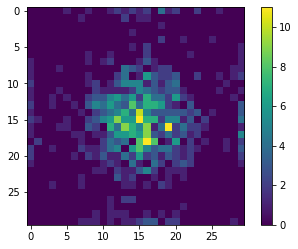

In [107]:
N=30
nu=2.5
threshold=0.0001

filename_strike = f"C:\\Users\\gabri\\Desktop\\Capstone\\data\\{N}_{nu}_{threshold}_strikedata.txt"
strike_file = open(filename_strike,'r')
strike_data_str = strike_file.read()
strike_data_str = strike_data_str.split('#')[:-1]

strike_data = np.zeros((N, N))
for point in strike_data_str:
    point = point.split(',')
    x_coord = point[1]
    y_coord = point[2]
    x_coord = x_coord.strip()
    y_coord = y_coord.strip()
    y_coord = y_coord.strip(')')
    strike_data[int(x_coord), int(y_coord)] += 1

cmap = matplotlib.cm.viridis
plt.imshow(strike_data, cmap=cmap)
plt.colorbar()
plt.show()

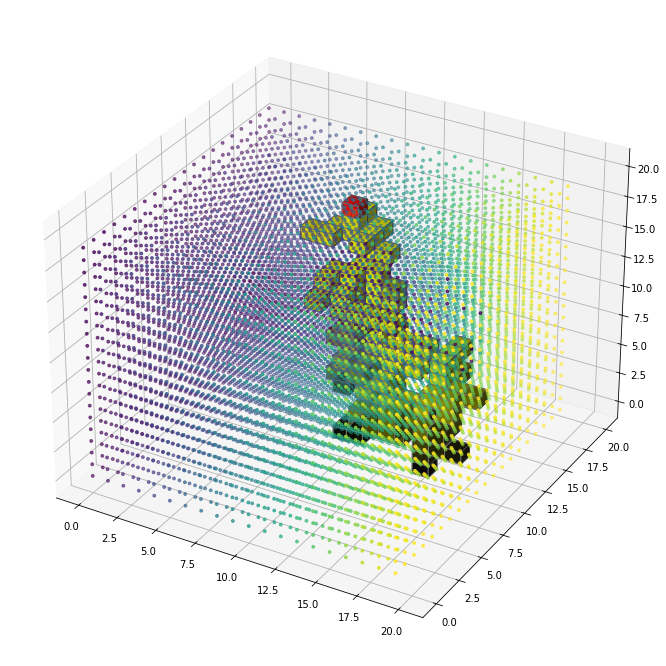

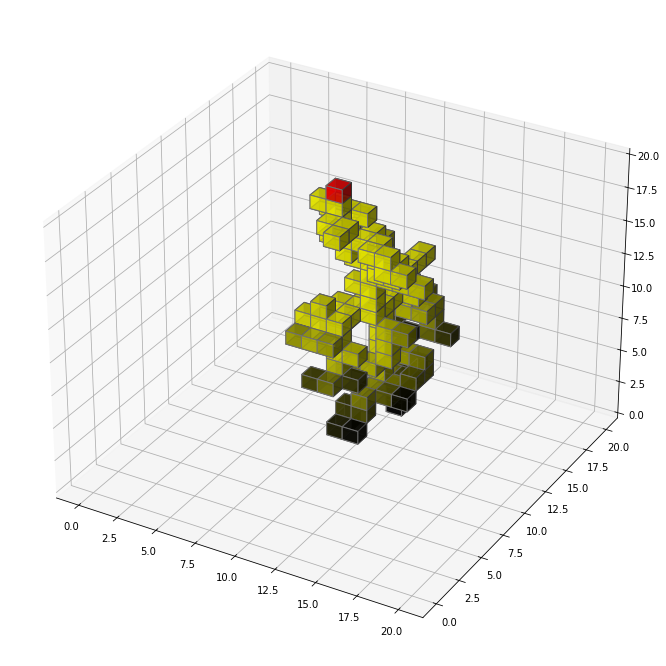

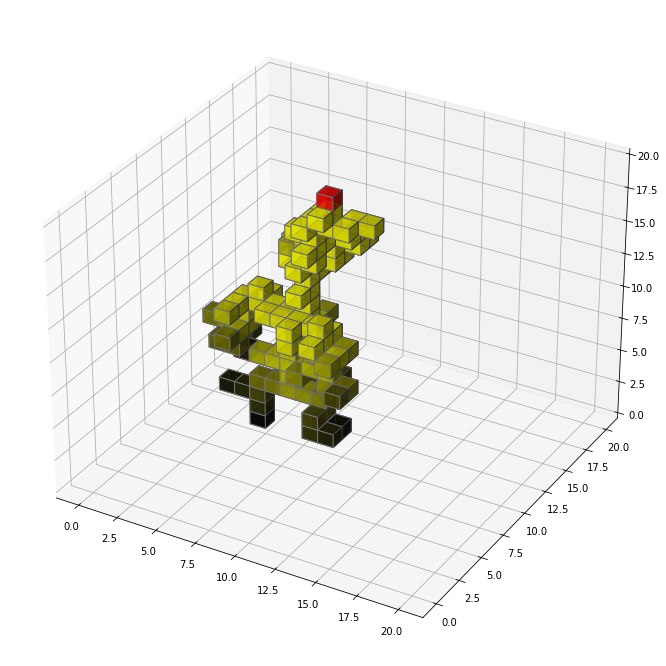

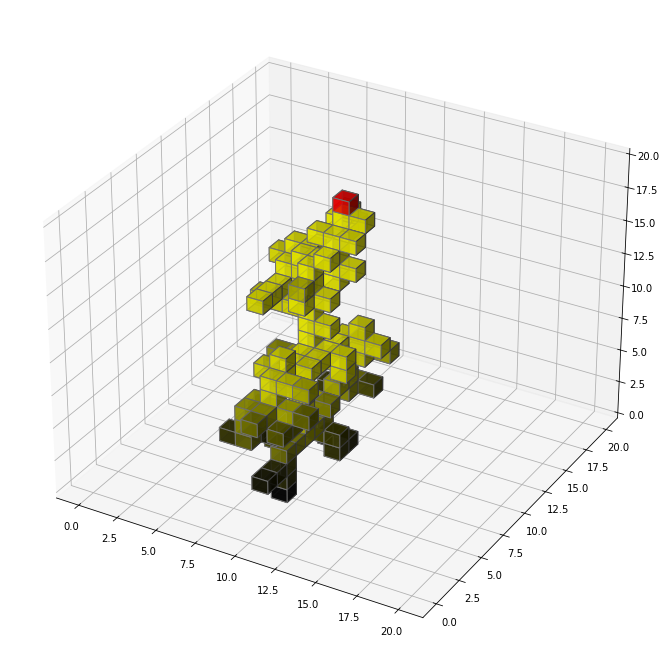

In [50]:
# Import libraries
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np


data = sim_instance.track_structure != 0
data = np.rot90(data, k=1, axes=(2,0))

# Create axis
axes = [data.shape[0], data.shape[1], data.shape[2]]

# Control Transparency
alpha = 0.8

# Control colour
colors = np.empty(axes + [4], dtype=np.float32)
#colors[2,2,4] = [1, 0, 0, alpha]
#colors[2,2,3] = [0, 1, 0, alpha]
#colors[2,1,2] = [0, 0, 1, alpha]

colors[:] = [1, 1, 0, alpha] # yellow

max_val = np.max(sim_instance.track_structure)
length = sim_instance.track_structure.shape[0]
for x in range(length):
    for y in range(length):
        for z in range(length):
            prog_val = sim_instance.track_structure[x,y,z]/max_val
            if sim_instance.track_structure[x,y,z] == 1:
                colors[x, y, z] = [1, 0, 0, alpha]
            else:
                colors[x, y, z] = [1-prog_val**3, 1-prog_val**3, 0, alpha]

colors = np.rot90(colors, k=1, axes=(2,0))

#colors[0] = [1, 0, 0, alpha] # red
#colors[1] = [0, 1, 0, alpha] # green
#colors[:] = [0, 0, 1, alpha] # blue
#colors[4] = [1, 1, 1, alpha] # grey

# Plot figure
fig = plt.figure(figsize=(18,12))
ax = fig.add_subplot(111, projection='3d')

x = np.arange(data.shape[0])
y = np.arange(data.shape[1])
z = np.arange(data.shape[2])

X, Y, Z = np.meshgrid(x, y, z)
X = np.rot90(X, k=1, axes=(2,0))
Y = np.rot90(Y, k=1, axes=(2,0))
Z = np.rot90(Z, k=1, axes=(2,0))

X_flat = X.flatten()
Y_flat = Y.flatten()
Z_flat = Z.flatten()

scatter_colors = []
gradient = plt.get_cmap('viridis')
for i in range(len(X_flat)):
    scatter_colors.append(gradient(sim_instance.potential[X_flat[i], Y_flat[i], Z_flat[i]]))


ax.scatter(X_flat, Y_flat, Z_flat, s=8, color=scatter_colors)

# Voxels is used to customizations of
# the sizes, positions and colors.
ax.voxels(data, facecolors=colors, edgecolors='grey');


for _ in range(3):
    data = np.rot90(data, k=1, axes=(0,1))
    colors = np.rot90(colors, k=1, axes=(0,1))
    fig = plt.figure(figsize=(18,12))
    ax = fig.add_subplot(111, projection='3d')

    # Voxels is used to customizations of
    # the sizes, positions and colors.
    ax.voxels(data, facecolors=colors, edgecolors='grey');




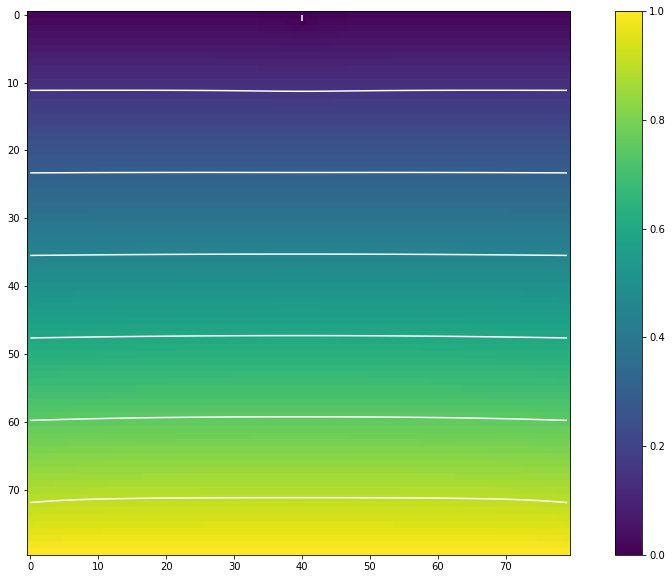

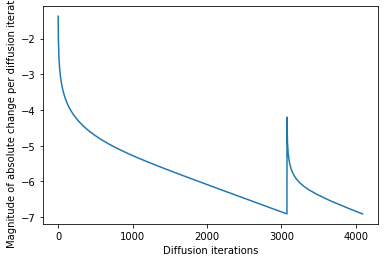

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.34it/s]


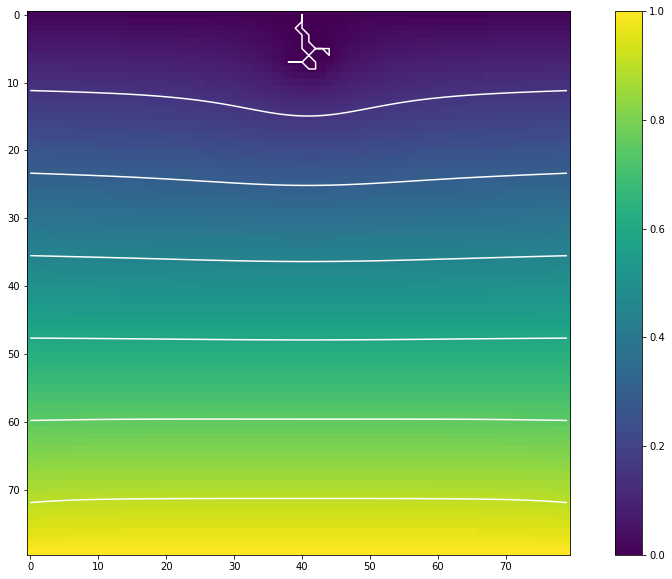

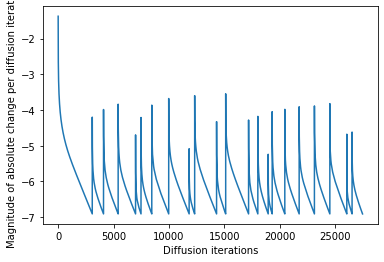

In [4]:
rnd.seed(10)
sim_instance = DBM_cube(width=80, height=80, n=1.5, threshold=0.001)

sim_instance.update()
sim_instance.display_state(sim_instance.potential)
plt.plot(np.log(sim_instance.difference_per_conv))
plt.xlabel("Diffusion iterations")
plt.ylabel("Magnitude of absolute change per diffusion iteration")
plt.show()

for _ in tqdm(range(20)):
  sim_instance.update()

sim_instance.display_state(sim_instance.potential)
plt.plot(np.log(sim_instance.difference_per_conv))
plt.xlabel("Diffusion iterations")
plt.ylabel("Magnitude of absolute change per diffusion iteration")

plt.show()

prev_difference_per_conv = sim_instance.difference_per_conv[:]